## Tonkin-Hill SARS-CoV-2 data analysis

Fastq data was downloaded from SRA and aligned (minimap2) by Matt Chung using accessions: PRJEB37886 and PRJEB42623. Additional information and the intial analyses of these data can be found at: https://elifesciences.org/articles/66857#data. 

In summary, the authors took ~1181 samples from ENA that had good enough coverage to generate consensus sequences and resequenced them.

Our goal was to determine how similar sequencing replicates are when looking at data generated by other groups and determine if our suggested methods of SNV analysis are sound. 

Coverage data was pulled using standard timo output. 

Minor variants were pulled from individual replicates before making comparisons. Our requirements were the SNVs had to be present at >=1% freq, >=200x read depth, and both replicates to be considered 'shared' SNVs. 

Both iVar and timo were run using 0.001 and 1x inputs. 



### Necessary inputs: 
- COV19.genome.coverage.pass.check.200.csv
- PRJEB37886_metadata.txt
- PRJEB42623_metadata.txt
- SARS.ivar.200.0.01.minor.csv
- COV19.minor.csv


#### Written by: Kate Johnson

In [1]:
suppressMessages({
message("Loading packages")
library('ggplot2')
library('plyr')
library('tidyverse')
library('dplyr')
library('glue')
library('UpSetR')
library("VennDiagram")})

In [2]:
# Plot themes to make plotting easier
PlotTheme1 = theme_bw() +
            theme(axis.line = element_line(colour = "black"),
              axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1),
              panel.grid.major = element_blank(),
              panel.grid.minor = element_blank(),
              panel.border = element_blank(),
              panel.background = element_blank(),
              strip.background = element_rect(colour="black", fill="white"),
              text = element_text(size = 8))

PlotTheme2 = theme_bw() +
                theme(legend.key = element_blank(),
                strip.background = element_rect(colour="black", fill="white"),
              text = element_text(size = 8))

# completely blank backgrounds
PlotTheme3 = theme(
                panel.grid.major = element_blank(),
                panel.grid.minor = element_blank(),
                panel.background = element_blank(),
                axis.line = element_line(colour = "black"),
                legend.key = element_blank(),
                strip.background = element_rect(colour="black", fill="white"),
              text = element_text(size = 8))

In [3]:
message("Set up working directory")

wkdir = '../tonkin_hill_data/'

setwd(wkdir)

Set up working directory



In [4]:
message("Generate necessary directories")

FIG_DIR = glue("{wkdir}/figures/")

if (!dir.exists(FIG_DIR)) {
      dir.create(FIG_DIR)
    }

message('figures will be saved in: ', FIG_DIR)

Generate necessary directories

figures will be saved in: ../tonkin_hill_data//figures/



# Load in metadata for Tonkin-Hill samples and pull out sample names

In [5]:
r1 = read.csv(glue("{wkdir}/metadata/PRJEB37886_metadata.txt"),
         header=T, sep="\t", na.strings = c(''))

r2 = read.csv(glue("{wkdir}/metadata/PRJEB42623_metadata.txt"),
         header=T, sep="\t", na.strings = c(''))

rep1_names = levels(factor(r1$ENA_Run))

rep2_names = levels(factor(r2$ENA_Run))

# Load in coverage information:
- load
- pull out rep 1 and rep 2
- merge r1 and r2 data into one file to compare
- add in zeros for samples that had 0 coverage

In [6]:
# load in coverage information: 
cov = read.csv(glue("{wkdir}/coverage/COV19.genome.coverage.pass.check.200.csv"),
         header=T, sep=",", na.strings = c(''))

c1 = cov %>% filter(name %in% rep1_names)
c1 = merge(c1, r1, by.x = 'name', by.y = 'ENA_Run', all.x= TRUE)

c2 = cov %>% filter(name %in% rep2_names)
c2 = merge(c2, r2, by.x = 'name', by.y = 'ENA_Run', all.x= TRUE)

c = merge(c1, c2, by = c('COG_ID', 'segment','gene_id'), all.x = TRUE)

c$percentage.x[is.na(c$percentage.x)] = 0 
c$percentage.y[is.na(c$percentage.y)] = 0 

# Supp. Fig. 7A: comparing rep 1 and rep 2 % coverage at 200x

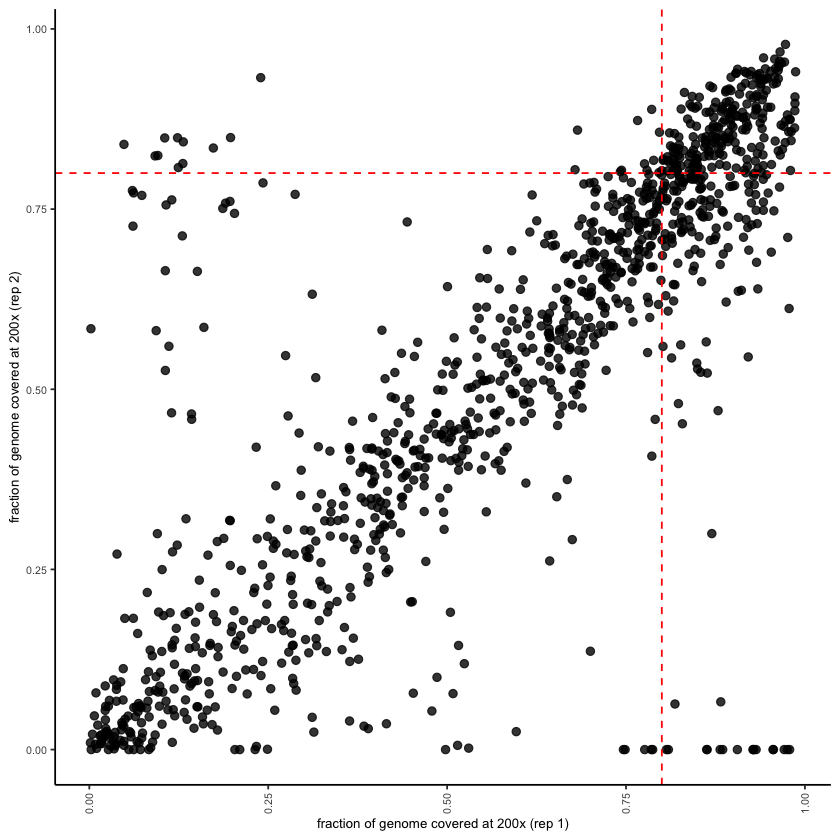

In [7]:
p1 = ggplot(c, aes(x=percentage.x, y=percentage.y)) +
    geom_point(alpha = 0.80, size = 2) +
    geom_hline(yintercept = 0.80, linetype = 2, color = 'red') +
    geom_vline(xintercept = 0.80, linetype = 2, color = 'red') + 
    PlotTheme1 +
    labs(x = 'fraction of genome covered at 200x (rep 1)',
        y = 'fraction of genome covered at 200x (rep 2)')

print(p1)

ggsave(p1,
       filename = glue("{FIG_DIR}/fig.S7A.samples.coverage.png"),
       width = 5,
       height = 5, limitsize=FALSE)

ggsave(p1,
       filename = glue("{FIG_DIR}/fig.S7A.samples.coverage.pdf"),
       width = 5,
       height = 5, limitsize=FALSE, useDingbats = FALSE)

### Filter for samples with at least 200x coverage across 80% of the genome for both reps and pull rep names

In [8]:
# filter samples for 200x coverage across 80% genome
c_filt = c %>% filter(percentage.x >= 0.80 & percentage.y >= 0.80) %>%
    unique()

rep1_names = levels(factor(c_filt$name.x))

rep2_names = levels(factor(c_filt$name.y))

In [9]:
message("Total number of samples remaining after filtering: ", length(rep1_names))
length(rep1_names) == length(rep2_names) # make sure they are the same length

Total number of samples remaining after filtering: 227



[1] TRUE

## Inset for Supp. Fig. 7A. % of genome covered for samples used during the remaining analyses.

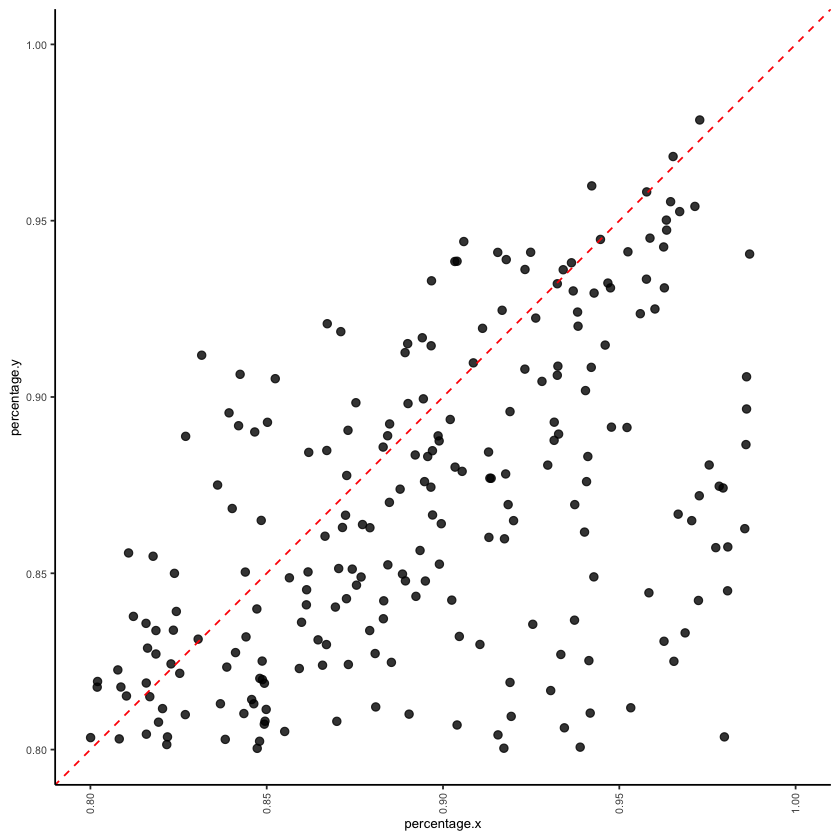

In [10]:
p2 = ggplot(c_filt, aes(x=percentage.x, y=percentage.y)) +
    geom_point(alpha = 0.80, size = 2) +
    geom_abline(linetype = 2, color = 'red') +
    xlim(0.80, 1.00) +
    ylim(0.80, 1.00) + 
    PlotTheme1

print(p2)
ggsave(p2,
       filename = glue("{FIG_DIR}/fig.S7A.inset.80.png"),
       width = 5,
       height = 5, limitsize=FALSE)

ggsave(p2,
       filename = glue("{FIG_DIR}/fig.S7A.inset.80.pdf"),
       width = 5,
       height = 5, limitsize=FALSE, useDingbats = FALSE)

# Read in iVar variants: 
- pulled variants from iVar outputs 
- pull r1 and r2 samples that pass our coverage requirements
- merge r1 and r2 samples into the same df
- add in 0's for minor snvs that are not shared

In [11]:
# read in ivar minors
ivar_minor = read.csv(glue("{wkdir}/variants/SARS.ivar.200.0.01.minor.csv"),
         header=T, sep=",", na.strings = c(''))

ivar1 = merge(ivar_minor %>% filter(sample %in% rep1_names) %>% unique(),
              r1, 
              by.x = c('sample'),
              by.y = c('ENA_Run'),
             all.x = TRUE)

ivar2 = merge(ivar_minor %>% filter(sample %in% rep2_names) %>% unique(),
              r2, 
              by.x = c('sample'),
              by.y = c('ENA_Run'),
             all.x = TRUE)

ivar = merge(ivar1, ivar2, 
             by = c('segment','ntpos','nt','vartype','refnt','COG_ID'),
            all = TRUE)

ivar$varfreq.x[is.na(ivar$varfreq.x)] = 0
ivar$varfreq.y[is.na(ivar$varfreq.y)] = 0

# Read in timo variants:
- import timo
- filter for r1 and r2 samples that pass our required cov. thresholds
- merge data
- add 0's for SNVs that were only found in one rep

In [12]:
timo_minor = read.csv(glue("{wkdir}/variants/COV19.minor.csv"),
         header=T, sep=",", na.strings = c('')) %>%
    select('name','segment',
          'ntpos','major','minor', 'majorfreq',
          'minorfreq','refnt','type') %>%
    unique()

timo1 = merge(timo_minor %>% filter(name %in% rep1_names) %>% unique(),
              r1, 
              by.x = c('name'),
              by.y = c('ENA_Run'),
             all.x = TRUE)

timo2 = merge(timo_minor %>% filter(name %in% rep2_names) %>% unique(),
              r2, 
              by.x = c('name'),
              by.y = c('ENA_Run'),
             all.x = TRUE)

timo = merge(timo1, timo2, 
             by = c('segment','ntpos','minor','major','refnt','type','COG_ID'),
            all = TRUE)

timo$minorfreq.x[is.na(timo$minorfreq.x)] = 0

timo$minorfreq.y[is.na(timo$minorfreq.y)] = 0

## Count the number of SNVs found in both reps for iVar and timo outputs

In [13]:
ivar_count = ivar %>%
    rowwise() %>%
    mutate(shared = ifelse(varfreq.x >= 0.01 & varfreq.y >= 0.01, 'yes','no')) %>%
    ungroup() %>%
    group_by(COG_ID, shared) %>%
    tally() %>%
    ungroup() %>%
    pivot_wider(., names_from = 'shared', values_from = 'n') %>%
    unique()

ivar_count$percentage = ivar_count$yes/(ivar_count$yes + ivar_count$no)

timo_count = timo %>% rowwise() %>%
    mutate(shared = ifelse(minorfreq.x >= 0.01 & minorfreq.y >= 0.01, 'yes', 'no')) %>%
    ungroup() %>%
    group_by(COG_ID, shared) %>%
    tally() %>%
    ungroup() %>%
    pivot_wider(., names_from = 'shared', values_from = 'n') %>%
    unique()

timo_count$percentage = timo_count$yes/(timo_count$yes + timo_count$no)

# Using the samples that pass our cutoff requirements, compare the number of shared SNVs out of total SNVS found for timo and iVar

In [14]:
# ivar vs. timo percentage 
c_filt = c_filt %>% select(COG_ID, percentage.x, percentage.y) %>% unique()
colnames(c_filt) = c('COG_ID','COV_PERCENT_R1','COV_PERCENT_R2') 

In [15]:
count_df = merge(ivar_count, timo_count, by = c('COG_ID'), all = TRUE)
count_df$percentage.x[count_df$percentage.x] = 0
count_df$percentage.y[count_df$percentage.y] = 0
count_df = merge(count_df, c_filt, by = c('COG_ID'))

count_df = count_df %>%
    rowwise() %>%
    mutate(cov_mean = (COV_PERCENT_R1 + COV_PERCENT_R2)/2) %>%
    ungroup() %>%
    unique()

# Supp. Fig. 7B: number of SNVs shared between timo rep outputs vs. iVar rep outputs

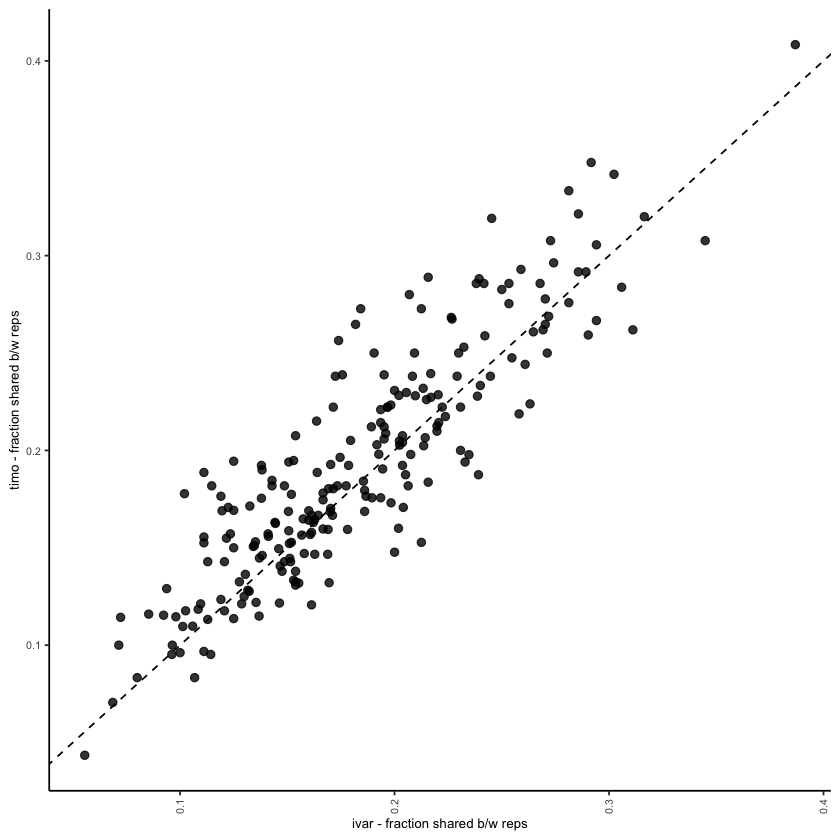

In [16]:
## USE USE USE##
p3 = ggplot(count_df, aes(x=percentage.x, y=percentage.y)) + 
       geom_point(size = 2, alpha = 0.8) + 
    PlotTheme1 +
    labs(x='ivar - fraction shared b/w reps',
         y='timo - fraction shared b/w reps') +
    geom_abline(linetype = 2, color = 'black')

print(p3)
ggsave(p3,
       filename = glue("{FIG_DIR}/fig.S7B.fraction.shared.reps.png"),
       width = 5,
       height = 5, limitsize=FALSE)

ggsave(p3,
       filename = glue("{FIG_DIR}/fig.S7B.fraction.shared.reps.pdf"),
       width = 5,
       height = 5, limitsize=FALSE, useDingbats = FALSE)


# Pull out shared SNVs for Venn Diagram

In [17]:
shared_timo = timo %>%
    rowwise() %>%
    mutate(shared_timo = ifelse(minorfreq.x >= 0.01 & minorfreq.y >=0.01, 'timo_yes','timo_no')) %>%
    ungroup() %>%
    unique() %>%
    select(COG_ID,ntpos, minor, shared_timo) %>%
    unique() 

shared_ivar = ivar %>%
    rowwise() %>%
    mutate(shared_ivar = ifelse(varfreq.x >= 0.01 & varfreq.y >= 0.01, 'ivar_yes','ivar_no')) %>%
    ungroup() %>%
    unique() %>%
    select(COG_ID,ntpos, nt,shared_ivar) %>%
    unique() 

colnames(shared_ivar) = c('COG_ID','ntpos','minor','shared_ivar')

In [18]:
rep1_df = merge(timo1, ivar1, 
                 by.x = c('name','segment','ntpos',
                         'minor','refnt','type','COG_ID'),
                 by.y=c('sample','segment','ntpos','nt',
                       'refnt','vartype','COG_ID'),
                 all = TRUE)

rep1_df$minorfreq[is.na(rep1_df$minorfreq)] = 0 

rep1_df$varfreq[is.na(rep1_df$varfreq)] = 0 

shared_R1 = rep1_df %>%
    rowwise() %>%
    mutate(shared_callers1 = ifelse(minorfreq >= 0.03 & varfreq >= 0.03, 'r1_yes','r1_no')) %>%
    ungroup() %>%
    unique() %>%
    select(COG_ID, ntpos, minor, shared_callers1) %>%
    unique() 

rep2_df = merge(timo2, ivar2, 
                 by.x = c('name','segment','ntpos',
                         'minor','refnt','type','COG_ID'),
                 by.y=c('sample','segment','ntpos','nt',
                       'refnt','vartype','COG_ID'),
                 all = TRUE)

rep2_df$minorfreq[is.na(rep2_df$minorfreq)] = 0 
rep2_df$varfreq[is.na(rep2_df$varfreq)] = 0 

shared_R2 = rep2_df %>%
    rowwise() %>%
    mutate(shared_callers2 = ifelse(minorfreq >= 0.03 & varfreq >= 0.03, 'r2_yes','r2_no')) %>%
    ungroup() %>%
    unique() %>%
    select(COG_ID, ntpos, minor, shared_callers2) %>%
    unique() 

In [19]:
shared_ivar$comp = paste0(shared_ivar$COG_ID,'_',shared_ivar$ntpos,'_', shared_ivar$minor)
shared_ivar = shared_ivar %>% select(-COG_ID, -ntpos, -minor)

shared_timo$comp = paste0(shared_timo$COG_ID,'_',shared_timo$ntpos,'_', shared_timo$minor)
shared_timo = shared_timo %>% select(-COG_ID, -ntpos, -minor)

shared_R1$comp = paste0(shared_R1$COG_ID,'_',shared_R1$ntpos,'_', shared_R1$minor)
shared_R1 = shared_R1 %>% select(-COG_ID, -ntpos, -minor)

shared_R2$comp = paste0(shared_R2$COG_ID,'_',shared_R2$ntpos,'_', shared_R2$minor)
shared_R2 = shared_R2 %>% select(-COG_ID, -ntpos, -minor)

In [20]:
set1 = c((shared_ivar %>% filter(shared_ivar == 'ivar_yes') %>% unique())$comp)
set2 = c((shared_timo %>% filter(shared_timo == 'timo_yes') %>% unique())$comp)
set3 = c((shared_R1 %>% filter(shared_callers1 == 'r1_yes') %>% unique())$comp)
set4 = c((shared_R2 %>% filter(shared_callers2 == 'r2_yes') %>% unique())$comp)

# Supp. Fig 7C. Venn Diagram of shared SNVs

In [21]:
mycol = c('#009E73','#CCD2EB','gray','lightgray')
v = venn.diagram(
        x = list(set1, set2, set3, set4),
        category.names = c("r1 v. r2 (iVar)" , "r1 v. r2 (timo)" , "timo v. ivar (r1)", "timo v. ivar (r2)"),
        #filename = 'snv.vennie.png',
        filename=NULL, 
        fill = mycol
        #output=TRUE,
 
);


pdf(file="fig.S7C.pdf")
    grid.draw(v)
dev.off()


pdf 
  2

In [22]:
sessionInfo()

R version 4.2.2 (2022-10-31)
Platform: x86_64-apple-darwin13.4.0 (64-bit)
Running under: macOS Catalina 10.15.7

Matrix products: default
BLAS/LAPACK: /opt/anaconda3/envs/renv/lib/libopenblasp-r0.3.21.dylib

locale:
[1] en_US.UTF-8/en_US.UTF-8/en_US.UTF-8/C/en_US.UTF-8/en_US.UTF-8

attached base packages:
[1] grid      stats     graphics  grDevices utils     datasets  methods  
[8] base     

other attached packages:
 [1] VennDiagram_1.7.3   futile.logger_1.4.3 UpSetR_1.4.0       
 [4] glue_1.6.2          forcats_0.5.2       stringr_1.5.0      
 [7] dplyr_1.0.10        purrr_0.3.5         readr_2.1.3        
[10] tidyr_1.2.1         tibble_3.1.8        tidyverse_1.3.2    
[13] plyr_1.8.8          ggplot2_3.4.0      

loaded via a namespace (and not attached):
 [1] Rcpp_1.0.9           lubridate_1.9.0      assertthat_0.2.1    
 [4] digest_0.6.31        utf8_1.2.2           IRdisplay_1.1       
 [7] R6_2.5.1             cellranger_1.1.0     repr_1.1.4          
[10] futile.options_1.0.1 